# Non linear LSTM

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from utils import print_nb_info, check_dir, SineModel, plot_loss, plot_forecast

In [2]:
print_nb_info()

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.4.0
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
rcParams['font.size'] = '12'
plt.rc('mathtext', fontset='cm')

In [4]:
SAVEFIG: bool = True
EXT: str = 'pdf'
FIG_PATH: Path = Path('./out/plots/lstm_2')
HORIZON: int = 10
constants: dict = {'save': SAVEFIG, 'extension': EXT, 'fig_path': FIG_PATH}

In [5]:
check_dir(FIG_PATH)

This directory exists: WindowsPath('C:/Users/YBant/Documents/projects/deep_learning/rnn/out/plots/lstm_2')


We will generate a time series of the form: $$x(t) = \sin(\omega t^2).$$ Meaning that the frequency and the period of the time wave changes over time.

In [6]:
series = np.sin((0.1 * np.arange(400)) * (0.1 * np.arange(400)))

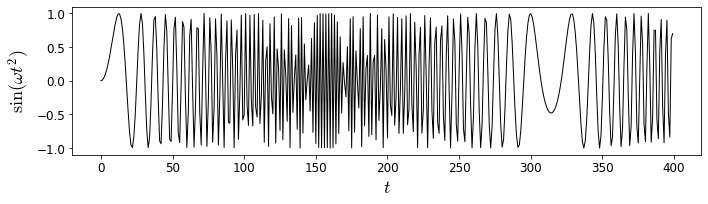

In [74]:
plt.figure(figsize=(10, 3))
plt.plot(series, c='k', lw=1, ls='-')
plt.xlabel(r'$t$', fontsize=18)
plt.ylabel(r'$\sin{(\omega t^2)}$', fontsize=18)
plt.tight_layout()
plt.show()

In [8]:
T: int = 10
D: int = 1
X_store: list = []
Y_store: list = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X_store.append(x)
    y = series[t+T]
    Y_store.append(y)

X = np.array(X_store).reshape(-1, T)
Y = np.array(Y_store)
N: int = len(X)
print(f"X.shape: {X.shape}, Y.shape: {Y.shape}")

X.shape: (390, 10), Y.shape: (390,)


Data split at 50% of the dataset:

In [9]:
X_train, y_train, X_val, y_val = X[:-N // 2], Y[:-N // 2], X[-N // 2:], Y[-N // 2:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((195, 10), (195,), (195, 10), (195,))

In [10]:
len_train, len_val = len(y_train), len(y_val)

## Section 1. Autoregressive Linear Model

Next, we are going to build an autoregressive linear model using TensorFlow's Functional API:

In [58]:
model_name = 'linreg'
epochs = 80
lr = 0.01
bs = 32
loss = 'mse'

In [59]:
inputs = Input(shape=(T,))
x = Dense(1)(inputs)
model = Model(inputs, x)
model.compile(loss=loss, optimizer=Adam(learning_rate=lr))

We can train the RNN:

In [60]:
r = model.fit(X_train, y_train, batch_size=bs, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

In [61]:
filename = f"{model_name}_loss_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(X_train)}"
filename

'linreg_loss_mse_epochs80_lr1e-02_len195'

Figure successfully saved in out\plots\lstm_2\linreg_loss_mse_epochs80_lr1e-02_len195.pdf


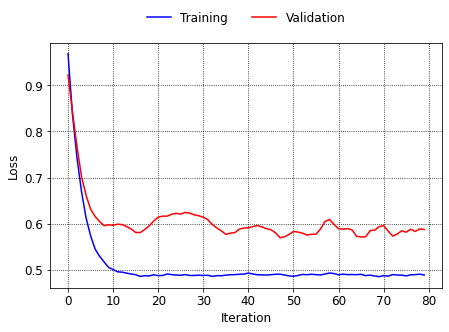

In [62]:
plot_loss(r, imgname=filename, **constants)

The loss per iteration is still high as fluctuating around 0.6 for the validation set. This is much higher that what we had before in the [Autoregressive Models with TensorFlow 2.3.1](https://github.com/kbantoec/deep_learning/blob/master/tf2/autoregressive_model.ipynb) notebook, but at least it appears to converge. So, probably our model is learning something useful.

## One-step forecast

In [63]:
forecast_type = 'onestep'

In [64]:
outputs = model.predict(X)

# The first half of X is our training set, and the second half is our test set
predictions = outputs[:, 0]

print(f"outputs.shape: {outputs.shape}, predictions.shape: {predictions.shape}")

outputs.shape: (390, 1), predictions.shape: (390,)


In [65]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(predictions)}"
filename

'linreg_pred_onestep_mse_epochs80_lr1e-02_len390'

Figure successfully saved in out\plots\lstm_2\linreg_pred_onestep_mse_epochs80_lr1e-02_len390.pdf


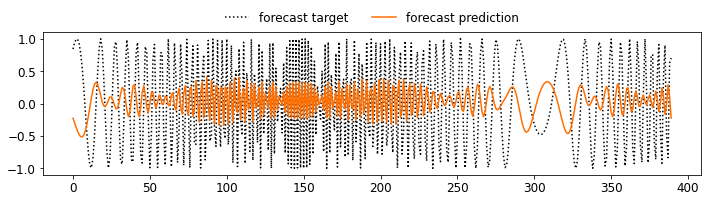

In [66]:
plot_forecast(predictions, Y, imgname=filename, **constants)

As we can see, the model does very bad at predicting the function. It does not even get the values in the right range. Knowing this, we can deduce that the multi-step forecast is going to be even worse.

Now, the one-step forecast using the true targets:

In [67]:
y_pred: list = []
i: int = -N // 2
while len(y_pred) < len(y_val):
    p = model.predict(X[i].reshape(1, -1))[0, 0]
    y_pred.append(p)
    i += 1

In [68]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'linreg_pred_onestep_mse_epochs80_lr1e-02_len195'

In [69]:
start = len(y_val) + HORIZON + 1

Figure successfully saved in out\plots\lstm_2\linreg_pred_onestep_mse_epochs80_lr1e-02_len195.pdf


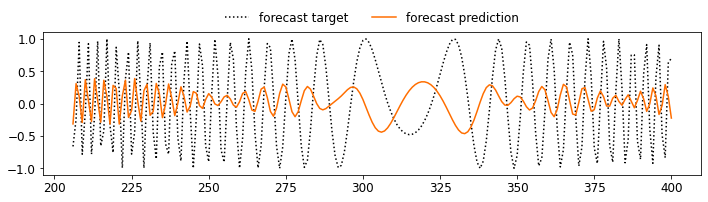

In [70]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

This plot is just the second half of the previous plot.

### Multi-step forecast

In [24]:
forecast_type = 'multistep'

In [25]:
y_pred = []
last_x = X[-N // 2]
print(f"last_x.shape: {last_x.shape}")

while len(y_pred) < len(y_val):
    p = model.predict(last_x.reshape(1, -1))[0, 0]
    y_pred.append(p)
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

last_x.shape: (10,)


In [26]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'linreg_pred_multistep_mse_epochs80_lr1e-02_len195'

Figure successfully saved in out\plots\lstm_2\linreg_pred_multistep_mse_epochs80_lr1e-02_len195.pdf


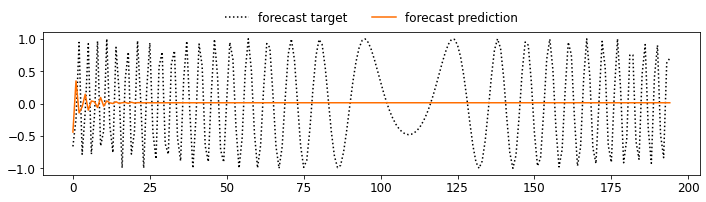

In [27]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

We were right about our suspicions. The linear model does a terrible job in forecasting the function we have generated.

## Section 2. Simple RNN

In [28]:
model_name = 'rnn'
epochs = 200
lr = 0.05
bs = 32
loss = 'mse'

In [29]:
X = X.reshape(-1, T, 1)  # Make it (N, T, D)
print(f"X.shape: {X.shape}")

inputs = Input(shape=(T, D))
x = SimpleRNN(10)(inputs)
x = Dense(1)(x)
model = Model(inputs, x)
model.compile(loss=loss, optimizer=Adam(learning_rate=lr))

X.shape: (390, 10, 1)


We train our Simple RNN model:

In [30]:
r = model.fit(X_train, y_train, batch_size=bs, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

In [31]:
filename = f"{model_name}_loss_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_train)}"
filename

'rnn_loss_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\rnn_loss_mse_epochs200_lr5e-02_len195.pdf


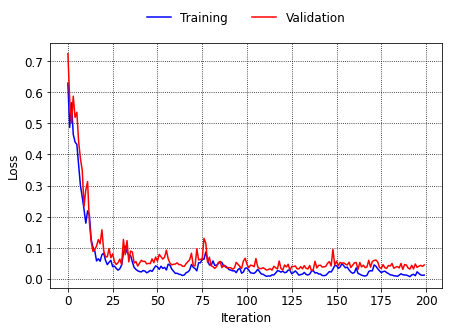

In [32]:
plot_loss(r, imgname=filename, **constants)

We observe that our loss is better than the linear model. There are some spikes and the loss does not seem to converge, but it is less than the 0.6 from before.

This shows us which models are relevant to use according to the task we want to achieve. Here the task is (1) making multi-step forecast, and (2) trying to predict simple time series based on a (3) nonlinear function with (4) no noise. While RNNs do better in this case, it is not consistently true when the underlying function is rather linear as for the regular sine wave. Then a linear model is most likely to outperform the RNN model as they have too much flexibility with respect to the autoregressive model.

But now that we have a more complex signal, a linear model cannot solve it. In this case, an RNN does better because of it has the required flexibility to match the signal.

### One-step forecast

In [33]:
forecast_type = 'onestep'

In [34]:
y_pred = []
i: int = -N // 2
while len(y_pred) < len(y_val):
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]  
    y_pred.append(p)
    i += 1

In [35]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'rnn_pred_onestep_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\rnn_pred_onestep_mse_epochs200_lr5e-02_len195.pdf


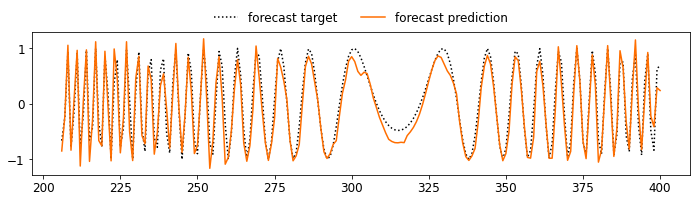

In [36]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

We observe that this models does a much better job as it matches the frequency in most places. Even if the signal slows down significantly in the second half of the plot. This is despite the fact that the model never saw such a low frequency in the training set! The values are also in the range of the targets.

### Multi-step forecast

In [37]:
forecast_type = 'multistep'

In [38]:
y_pred: list = []
last_x = X[-N // 2]

while len(y_pred) < len(y_val):
    pred = model.predict(last_x.reshape(-1, T, 1))[0, 0]
    y_pred.append(pred)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = pred

In [39]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'rnn_pred_multistep_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\rnn_pred_multistep_mse_epochs200_lr5e-02_len195.pdf


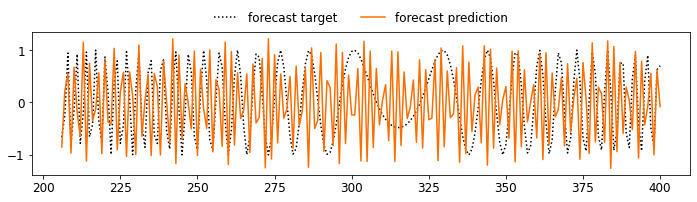

In [40]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

This does not look that good, but at least at the begining the model appears to capture the frequency. Nonetheless, the model does not know that in the second half of the plot, the signal slows down. It therefore seems almost logical that the model should not be able to predict this. Also, it does a much better job than the linear model at getting the righ range of values.

## Section 3. LSTM

In [41]:
model_name = 'lstm'
epochs = 200
lr = 0.05
bs = 32
loss = 'mse'

In [42]:
X = X.reshape(-1, T, 1)  # Make it (N, T, D)
print(f"X.shape: {X.shape}")

inputs = Input(shape=(T, D))
x = LSTM(10)(inputs)
x = Dense(1)(x)
model = Model(inputs, x)
model.compile(loss=loss, optimizer=Adam(learning_rate=lr))

X.shape: (390, 10, 1)


In [43]:
r = model.fit(X_train, y_train, batch_size=bs, epochs=epochs, validation_data=(X_val, y_val), verbose=0)

In [44]:
filename = f"{model_name}_loss_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_train)}"
filename

'lstm_loss_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\lstm_loss_mse_epochs200_lr5e-02_len195.pdf


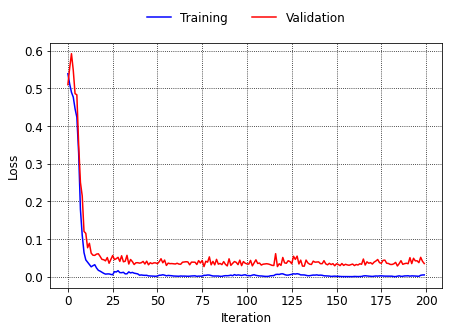

In [45]:
plot_loss(r, imgname=filename, **constants)

The loss is lower than for the Simple RNN and it seems to converge over iterations.

### One-step forecast

In [46]:
forecast_type = 'onestep'

In [47]:
y_pred = []

i: int = -N // 2

while len(y_pred) < len(y_val):
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]  
    y_pred.append(p)
    i += 1

In [48]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'lstm_pred_onestep_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\lstm_pred_onestep_mse_epochs200_lr5e-02_len195.pdf


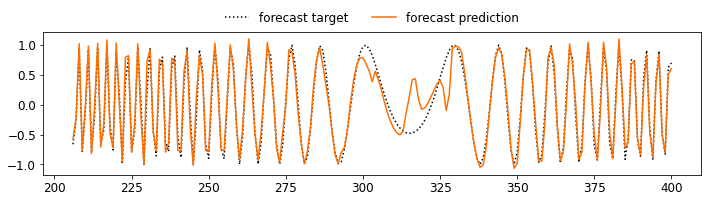

In [49]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

The lazy forecast:

In [50]:
outputs = model.predict(X)
print(f"outputs.shape: {outputs.shape}")
predictions = outputs[:, 0]

outputs.shape: (390, 1)


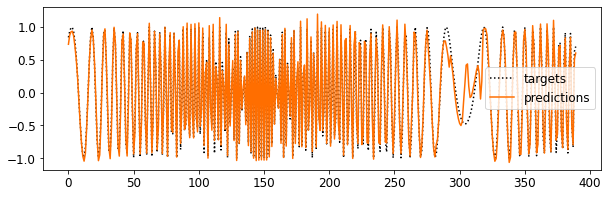

In [51]:
plt.figure(figsize=(10, 3))
plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

### Multi-step forecast

In [52]:
forecast_type = 'multistep'

In [53]:
y_pred: list = []
last_x = X[-N // 2]

while len(y_pred) < len(y_val):
    p = model.predict(last_x.reshape(-1, T, 1))[0, 0]
    y_pred.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [54]:
filename = f"{model_name}_pred_{forecast_type}_{loss}_epochs{epochs}_lr{lr:.0e}_len{len(y_pred)}"
filename

'lstm_pred_multistep_mse_epochs200_lr5e-02_len195'

Figure successfully saved in out\plots\lstm_2\lstm_pred_multistep_mse_epochs200_lr5e-02_len195.pdf


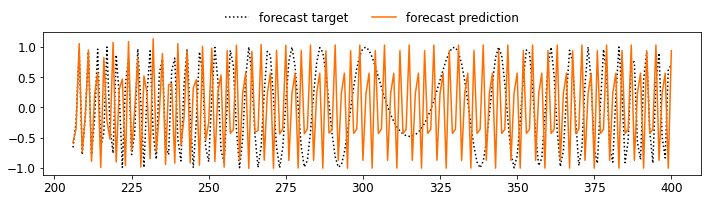

In [55]:
plot_forecast(y_pred, y_val, imgname=filename, starts_at=start, **constants)

The lazy forecast:

In [56]:
y_pred: list = []
last_x = X[-N // 2]

while len(y_pred) < len(Y[-N//2:]):
    p = model.predict(last_x.reshape(-1, T, 1))[0, 0]
    y_pred.append(p)
    
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

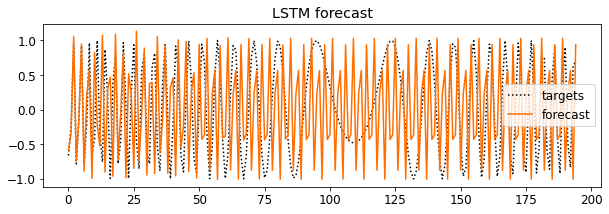

In [57]:
plt.figure(figsize=(10, 3))
plt.plot(y_val, label='targets')
plt.plot(y_pred, label='forecast')
plt.title('LSTM forecast')
plt.legend()
plt.show()

This is still not so great. The LSTM model cannot capture the low frequency portion of the signal. So, this is pretty much the same as the Simple RNN. But why? Well, we should not think that because LSTMs are more popular than RNNs they should be more powerful, and therefore LSTMs are better and they can do anything. This is way of reasoning is wrong. And we just have proven it with the plot above. So, we should aoid absolute generalizations like this.

LSTMs are better than RNNs at capturing long-term dependencies. This does not mean that LSTMs are simply better at everything. LSTMs aren't magic.

Although LSTMs are better at capturing long-term dependencies, it is important to realize that this fact does not hold true for arbitrarily long term dependencies. There is a point where even LSTMs forget. Of course, this point is farther than for Simple RNNs, but it exsits, nonetheless.

It is also worth to mention that there is no real advantage to using LSTMs for our problem because because our dataset does not really exhibit any long-term dependencies. At least, for the time span of the dataset as it is right now. Meaning that data from very far in the past is not going to help us predict future values.